In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fenics as fe
import os                             # allows to use path
import pandas as pd

In [2]:
# Create XMDF file for the results
out_path = 'Results'
os.makedirs(out_path, exist_ok=True)
results = xdmffile = fe.XDMFFile(os.path.join(out_path,"Results1" + ".xdmf"))
results.parameters["flush_output"] = True
results.parameters["functions_share_mesh"] = True

In [3]:
# --------------------------------
# Test Parameters
# --------------------------------

MinS   = 1.0                   # Min stretch (-)
MaxS   = 2                   # Max stretch (-)
Ssteps = 0.02                  # Stretch step (-)

NumSteps = (MaxS-MinS)/Ssteps  # Number of steps (-)

In [4]:
# --------------------------------
# FE Parameters
# --------------------------------

# Geometry (mm)
Length    = 5
Thickness = 5
Height    = 5

# Discretization
Nelements = 5
Type      = 'Lagrange'
PolDegree = 1

# Mesh
mesh = fe.BoxMesh(fe.Point(-Length/2, -Thickness/2, -Height/2),
                  fe.Point( Length/2,  Thickness/2,  Height/2),
                  Nelements, Nelements, Nelements)

# Original surface normals of the cube
Normals = fe.FacetNormal(mesh)

# Functions space
V_ele = fe.VectorElement(Type, mesh.ufl_cell(), PolDegree)
V = fe.VectorFunctionSpace(mesh, Type, PolDegree)

W_ele = fe.FiniteElement(Type, mesh.ufl_cell(), PolDegree)
W     = fe.FunctionSpace(mesh, Type, PolDegree)

Z_ele = fe.TensorElement(Type, mesh.ufl_cell(), PolDegree)
Z     = fe.TensorFunctionSpace(mesh, Type, PolDegree)

# Finite element functions
du = fe.TrialFunction(V)
v  = fe.TestFunction(V)
u  = fe.Function(V)
u.rename('Displacement(mm)', '')

mesh

In [5]:
# --------------------------------
# Mechanics Parameters
# --------------------------------

# Material Constants
Nu     = 0.49                        #   (-)
Mu     = 0.53                        #   (kPa)
E      = 2*Mu*(1+Nu)                 #   (kPa)
Lambda = 2*Mu*Nu/(1-2*Nu)            #   (kPa)
Kappa  = 2*Mu*(1+Nu)/(3*(1-2*Nu))    #   (kPa)

print('Mu     = ',float(Mu), '(kPa)')
print('Nu     = ',float(Nu), '(-)')
print('E      = ',float(E), '(kPa)')
print('Lambda = ',float(Lambda), '(kPa)')
print('Kappa  = ',float(Kappa), '(kPa)')

# Kinematics
d   = u.geometric_dimension()
I   = fe.Identity(d)                  # Identity tensor
F   = I + fe.grad(u)                  # Deformation gradient
F   = fe.variable(F)                  # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation
eps = 1/2 * (F + F.T - I)             # Small (or infinitesimal) strain tensor
C   = F.T*F                           # Right Cauchy-Green deformation tensor
E   = 1/2 * (C - I)                   # Green-Lagrange strain tensor

# Invariants
J   = fe.det(F)                       # Jacobian of F
I1  = fe.tr(C)                        # First invariant of Right Cauchy-Green deformation tensor

# Constitutive Models
Lin  = Mu*fe.inner(eps,eps) + Lambda/2 * fe.tr(eps)**2                  # Linear elasticity
SV_K = Mu*fe.inner(E,E) + Lambda/2 * fe.tr(E)**2                        # St-Venant Kirchoff model (most simple)
I_NH = Mu/2 * (I1 - 3)                                                  # Incompressible Neo-Hookean
C_NH = Mu/2 * (J**(-2/3)*I1 - 3) + Kappa/4 * ((J-1)**2 + fe.ln(J)**2)   # Compressible Neo-Hookean

Constitutive_Models = [Lin, SV_K, I_NH, C_NH]
ModelsNames = ['Linear', 'St-Venant Kirchoff','Incompressible NH','Compressible NH']

# Analytic solutions for nominal stress (first Piola-Kirchoff: P(F) = diff(Psi,F))
P_Lin = 2*Mu*eps + Lambda*fe.tr(eps)*I
P_SVK = F*(2*Mu*E + Lambda*fe.tr(E)*I)
P_INH = Mu * (F-1/3*I1*fe.inv(F.T))
P_CNH = Mu*J**(-2/3) * (F-1/3*I1*fe.inv(F.T)) + Kappa/2*J * (J-1 + 1/J * fe.ln(J)) * fe.inv(F.T)

Analytic_Solutions = [P_Lin, P_SVK, P_INH, P_CNH]

Mu     =  0.53 (kPa)
Nu     =  0.49 (-)
E      =  1.5794000000000001 (kPa)
Lambda =  25.969999999999974 (kPa)
Kappa  =  26.323333333333313 (kPa)


In [6]:
# --------------------------------
# Boundary conditions
# --------------------------------

# Define boundaries
class LowerSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], -Height/2, tol)
    
class UpperSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], Height/2, tol)

# Define Integration over subdomains
domains_facets  = fe.MeshFunction('size_t', mesh, mesh.geometric_dimension()-1)
ds = fe.Measure('ds', domain=mesh, subdomain_data=domains_facets)

# Mark facets all domain facets with 0
domains_facets.set_all(0)

# Mark bottom facets with 1
bottom = LowerSide()
bottom.mark(domains_facets, 1)

# Mark upper facets with 2
up = UpperSide()
up.mark(domains_facets, 2)

# Save in .pvd file
boundaries_file = fe.File(os.path.join(out_path, "boundaries.pvd"))
boundaries_file << domains_facets

# Boundary conditions
u_0 = fe.Constant((0))                                                             # No displacement
u_1 = fe.Expression(('(s-1)'), degree=1, s = MinS )                                # Displacement imposed

# u_0 = fe.Constant((0, 0, 0))                                                       # No displacement
# u_1 = fe.Expression(('0', '0', '(s-1)'), degree=1, s = MinS )                      # Displacement imposed

# Define bc as u_0 in the vector space V on the subdomain domains_facets labeled by 1 (lower facets)
bcl = fe.DirichletBC(V.sub(2), u_0, domains_facets, 1)
bcu = fe.DirichletBC(V.sub(2), u_1, domains_facets, 2)
# bcl = fe.DirichletBC(V, u_0, domains_facets, 1)
# bcu = fe.DirichletBC(V, u_1, domains_facets, 2)
bcs = [bcl, bcu]

In [7]:
# --------------------------------
# Solving
# --------------------------------

# Data frame to store values
cols  = ['Stretches','pzz','Pxx','Pyy','Pzz','Pxy','Pyx','Pxz','Pzx','Pyz','Pzy',
                           'Sxx','Syy','Szz','Sxy','Syx','Sxz','Szx','Syz','Szy',
                           'Txx','Tyy','Tzz','Txy','Tyx','Txz','Tzx','Tyz','Tzy']
df_FE = pd.DataFrame(columns=cols, index=range(int(round(NumSteps))+1))
df_An = pd.DataFrame(columns=cols, index=range(int(round(NumSteps))+1))

# Set Constitutive Model
CM = 3
Psi       = Constitutive_Models[CM]
ModelName = ModelsNames[CM]
P_An      = Analytic_Solutions[CM]

# Results File
results = xdmffile = fe.XDMFFile(os.path.join(out_path, ModelName, "Model.xdmf"))
results.parameters["flush_output"] = True
results.parameters["functions_share_mesh"] = True

# total potential energy 
Pi = Psi * fe.dx 

# Compute 1st variation of Pi (directional derivative about u in dir. of v)
Fpi = fe.derivative(Pi, u, v)

# Compute Jacobian of F
Jac = fe.derivative(Fpi, u, du)

# Problem formulation
problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac)
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)    
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'cg'
prm['newton_solver']['preconditioner'] = 'icc'

# Time-stepping
StretchState = MinS
for i in range(int(round(NumSteps))+1):
        
    # Update current state
    u_1.s = StretchState
    stretch = StretchState
    print('Stretch:   ', '%.2f'%stretch , '(-)')

    # Compute solution and save displacement
    solver.solve()
    results.write(u,StretchState)

    # First Piola Kirchoff (nominal) stress
    print("Nominal tress derivation and saving to file")
    P_FE = fe.diff(Psi, F)
    P_FE_project = fe.project(P_FE, Z, solver_type='cg')
    P_FE_project.rename("Nominal stress (kPa)", "")
    results.write(P_FE_project,StretchState)
    
    # Compute nominal stress vector
    p = fe.dot(P_FE,fe.Constant((0,0,1)))                           # Nominal stress vectors in direction of interest
    p_project = fe.project(p, V)
    p_project.rename("Nominal stress vector","")
    results.write(p_project,StretchState)

    # Compute nominal stress based on stress vector
    Rf_up = fe.assemble(fe.inner(p,Normals)*ds(2))          # Reaction force on upper surface in direction of interest
    Area  = fe.assemble(1*ds(2))
    
    # Second Piola Kirchoff (material) stress
    print("Material stress derivation and saving to file")
    S_FE = fe.inv(F) * fe.diff(Psi, F)
    S_FE_project = fe.project(S_FE, Z, solver_type='cg')
    S_FE_project.rename("Material stress (kPa)", "")
    results.write(P_FE_project,StretchState)
    
    # Cauchy (true or spatial) stress
    print("Spatial stress derivation and saving to file")
    T_FE = 1 / J * fe.diff(Psi, F) * F.T
    T_FE_project = fe.project(T_FE, Z, solver_type='cg')
    T_FE_project.rename("Spatial stress (kPa)", "")
    results.write(T_FE_project,StretchState)
    
    # Save values to table
    df_FE.loc[i].Stretches = stretch
    df_FE.loc[i].pzz = Rf_up/Area
    df_FE.loc[i].Pxx = fe.assemble(P_FE[0,0]*ds(2))
    df_FE.loc[i].Pyy = fe.assemble(P_FE[1,1]*ds(2))
    df_FE.loc[i].Pzz = fe.assemble(P_FE[2,2]*ds(2))
    df_FE.loc[i].Pxy = fe.assemble(P_FE[0,1]*ds(2))
    df_FE.loc[i].Pyx = fe.assemble(P_FE[1,0]*ds(2))
    df_FE.loc[i].Pxz = fe.assemble(P_FE[0,2]*ds(2))
    df_FE.loc[i].Pzx = fe.assemble(P_FE[2,0]*ds(2))
    df_FE.loc[i].Pyz = fe.assemble(P_FE[1,2]*ds(2))
    df_FE.loc[i].Pzy = fe.assemble(P_FE[2,1]*ds(2))
    df_FE.loc[i].Sxx = fe.assemble(S_FE[0,0]*ds(2))
    df_FE.loc[i].Syy = fe.assemble(S_FE[1,1]*ds(2))
    df_FE.loc[i].Szz = fe.assemble(S_FE[2,2]*ds(2))
    df_FE.loc[i].Sxy = fe.assemble(S_FE[0,1]*ds(2))
    df_FE.loc[i].Syx = fe.assemble(S_FE[1,0]*ds(2))
    df_FE.loc[i].Sxz = fe.assemble(S_FE[0,2]*ds(2))
    df_FE.loc[i].Szx = fe.assemble(S_FE[2,0]*ds(2))
    df_FE.loc[i].Syz = fe.assemble(S_FE[1,2]*ds(2))
    df_FE.loc[i].Szy = fe.assemble(S_FE[2,1]*ds(2))
    df_FE.loc[i].Txx = fe.assemble(T_FE[0,0]*ds(2))
    df_FE.loc[i].Tyy = fe.assemble(T_FE[1,1]*ds(2))
    df_FE.loc[i].Tzz = fe.assemble(T_FE[2,2]*ds(2))
    df_FE.loc[i].Txy = fe.assemble(T_FE[0,1]*ds(2))
    df_FE.loc[i].Tyx = fe.assemble(T_FE[1,0]*ds(2))
    df_FE.loc[i].Txz = fe.assemble(T_FE[0,2]*ds(2))
    df_FE.loc[i].Tzx = fe.assemble(T_FE[2,0]*ds(2))
    df_FE.loc[i].Tyz = fe.assemble(T_FE[1,2]*ds(2))
    df_FE.loc[i].Tzy = fe.assemble(T_FE[2,1]*ds(2))
    
    # Analytic Solution
    df_An.loc[i].Stretches = stretch    
    df_An.loc[i].Pxx = fe.assemble(P_An[0,0]*ds(2))
    df_An.loc[i].Pyy = fe.assemble(P_An[1,1]*ds(2))
    df_An.loc[i].Pzz = fe.assemble(P_An[2,2]*ds(2))
    df_An.loc[i].Pxy = fe.assemble(P_An[0,1]*ds(2))
    df_An.loc[i].Pyx = fe.assemble(P_An[1,0]*ds(2))
    df_An.loc[i].Pxz = fe.assemble(P_An[0,2]*ds(2))
    df_An.loc[i].Pzx = fe.assemble(P_An[2,0]*ds(2))
    df_An.loc[i].Pyz = fe.assemble(P_An[1,2]*ds(2))
    df_An.loc[i].Pzy = fe.assemble(P_An[2,1]*ds(2))

    # Update stretch state
    StretchState += Ssteps

Stretch:    1.00 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.02 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.04 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.06 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.08 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.10 (-)
Nominal tress derivation and saving to file
Material stress derivation and saving to file
Spatial stress derivation and saving to file
Stretch:    1.12 (-)
Nominal tress derivation and saving to file

          pzz       Pzz
0           0         0
1   0.0062923  0.157307
2   0.0125345  0.313363
3   0.0187275  0.468187
4   0.0248719  0.621797
5   0.0309685  0.774214
6   0.0370182  0.925454
7   0.0430215   1.07554
8   0.0489793   1.22448
9   0.0548921    1.3723
10  0.0607608   1.51902
11  0.0665859   1.66465
12  0.0723681    1.8092
13  0.0781082    1.9527
14  0.0838066   2.09516
15   0.089464    2.2366
16  0.0950811   2.37703
17   0.100658   2.51646
18   0.106197   2.65491
19   0.111696    2.7924
20   0.117158   2.92894
21   0.122582   3.06454
22   0.127969   3.19922
23   0.133319   3.33299
24   0.138634   3.46586
25   0.143914   3.59784
26   0.149158   3.72896
27   0.154369   3.85921
28   0.159545   3.98862
29   0.164688    4.1172
30   0.169798   4.24495
31   0.174876   4.37189
32   0.179921   4.49803
33   0.184935   4.62339
34   0.189918   4.74796
35   0.194871   4.87177
36   0.199793   4.99482
37   0.204685   5.11713
38   0.209548    5.2387
39   0.214382   5.35954
40   0.219187   

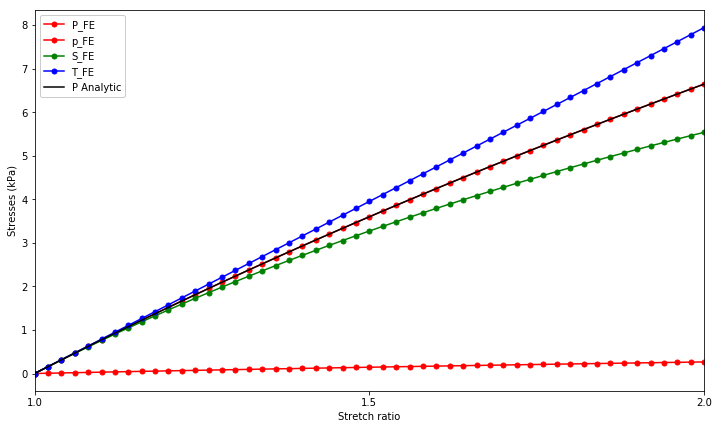

In [14]:
# --------------------------------
# Save Results
# --------------------------------

# Tables
# df_FE.to_pickle(os.path.join(out_path, ModelName, 'FE_Stresses'))
# df_An.to_pickle(os.path.join(out_path, ModelName, 'An_Stresses'))

print(df_FE[['pzz','Pzz']])

# Plots
plt.rc('figure', figsize=[12,7])
fig, ax = plt.subplots(1, 1)
Xaxis = 'Stretches'
Yaxis = ['Pzz', 'Szz', 'Tzz']

df_FE.plot(ax = ax, x = Xaxis, y = Yaxis[0], color = 'r', linestyle = '-', label = 'P_FE', marker = 'o', markersize = 5)
df_FE.plot(ax = ax, x = Xaxis, y = 'pzz', color = 'r', linestyle = '-', label = 'p_FE', marker = 'o', markersize = 5)
df_FE.plot(ax = ax, x = Xaxis, y = Yaxis[1], color = 'g', linestyle = '-', label = 'S_FE', marker = 'o', markersize = 5)
df_FE.plot(ax = ax, x = Xaxis, y = Yaxis[2], color = 'b', linestyle = '-', label = 'T_FE', marker = 'o', markersize = 5)
df_An.plot(ax = ax, x = Xaxis, y = Yaxis[0], color = 'k', linestyle = '-', label = 'P Analytic')

ax.set_xlabel('Stretch ratio')
ax.set_ylabel('Stresses (kPa)')
# ax.set_xlim(1,1.1)
# ax.set_ylim(0,1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.legend(loc='upper left', frameon=True, framealpha=1)
# plt.savefig(os.path.join(out_path, ModelName, 'Stresses_Comparison.pdf'))

Plot selected :  Traction of Basal Ganglia using Compressible NH Model


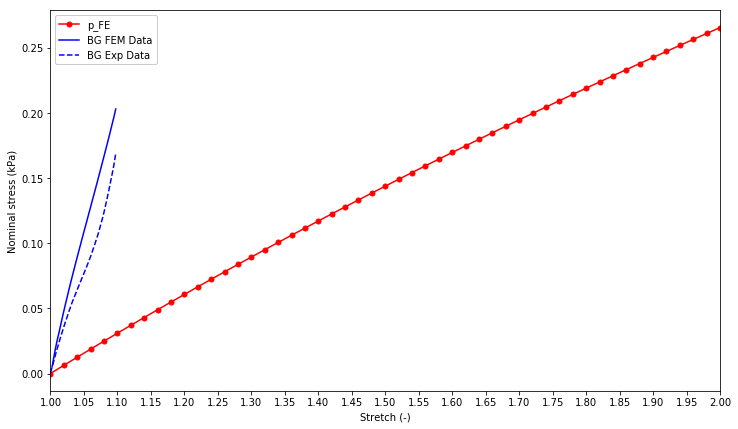

In [9]:
# Region of the brain
MainFolder = "Budday2019Data"
Regions = ["Basal Ganglia", "Corona Radiata", "Corpus Callosum", "Cortex"]
Region = Regions[0]

if Region == Regions[0]:
    Rn = "BasalGanglia"
    Rd = "BG"    
elif Region == Regions[1]:
    Rn = "CoronaRadiata"
    Rd = "CR"
elif Region == Regions[2]:
    Rn = "CorpusCallosum"
    Rd = "CC"
elif Region == Regions[3]:
    Rn = "Cortex"
    Rd = "C"

# Import reference data
# if u_1 == u_t:
FEMData = "Tension_OgdenFEM_Dat.csv"
ExpData = "Tension_ExpDat.csv"
Test = "Traction"
Xaxis = "Stretch (-)"
Yaxis = "Nominal stress (kPa)"
# elif u_1 == u_c:
#     FEMData = "Compression_OgdenFEM_Dat.csv"
#     ExpData = "Compression_ExpDat.csv"
#     Test = "Compression"
#     Xaxis = "Stretch (-)"
#     Yaxis = "Nominal stress (kPa)"
# elif u_1 == u_s:
#     FEMData = "SimpleShear_OgdenFEM_Dat.csv"
#     ExpData = "SimpleShear_ExpDat.csv"
#     Test = "Simple Shear"
#     Xaxis = "Shear (-)"
#     Yaxis = "Shear stress (kPa)"

FEMData = pd.read_csv(os.path.join("..", MainFolder, Rn, Rd + "_" + FEMData),delimiter=";", decimal=",",names=["FEM " + Xaxis,"FEM " + Yaxis])
ExpData = pd.read_csv(os.path.join("..", MainFolder, Rn, Rd + "_" + ExpData),delimiter=";", decimal=",",names=["Exp " + Xaxis,"Exp " + Yaxis])

datadf = pd.concat([FEMData, ExpData], axis=1)

# Print the output
# print(outputdf)
# print(datadf)

# Plot
print("Plot selected : ", Test, "of" ,Region, "using", ModelName, "Model")
fig, ax = plt.subplots(1, 1)
df_FE.plot(ax = ax, x = 'Stretches', y = 'pzz', color = 'r', linestyle = '-', label = 'p_FE', marker = 'o', markersize = 5)
datadf.plot(ax = ax, x = "FEM " + Xaxis, y = "FEM " + Yaxis, color = 'blue', linestyle = '-', label = Rd + ' FEM Data')
datadf.plot(ax = ax, x = "Exp " + Xaxis, y = "Exp " + Yaxis, color = 'blue', linestyle = '--', label = Rd + ' Exp Data')
ax.set_xlabel(Xaxis)
ax.set_ylabel(Yaxis)
# ax.set_xlim(State[0],State[-1])
# ax.set_ylim(Pstress[0],Pstress[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.legend(loc='upper left', frameon=True, framealpha=1)
# plt.savefig(os.path.join(out_path, 'NominalStress - ' + Name + "Comparison" +'.pdf'))